In [29]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import simpson
from scipy.ndimage import gaussian_filter
from wigner_from_data import wigner_from_data

from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import (
    calibrate_denoiser,
    denoise_wavelet,
    denoise_tv_chambolle,
    denoise_nl_means,
    estimate_sigma)
from skimage.util import img_as_float, random_noise
from skimage.color import rgb2gray
from functools import partial
from skimage.restoration import denoise_invariant

# Task A

## Utility Functions

In [2]:
#utility functions for affine distortions
#affinely distort wigner function
def affine_distort(wigner, alpha, b):
    return alpha*wigner+b

#add gaussian noise to wigner function
def add_gaussian_noise(wigner, sigma):
    noise = sigma*jax.random.normal(jax.random.key(0), wigner.shape)
    return jnp.add(wigner, noise)

def add_affine_gaussian_noise(wigner, alpha, b, sigma):
    #add afine first
    affine_wigner = affine_distort(wigner, alpha, b)
    #add gaussian noise
    return add_gaussian_noise(affine_wigner, sigma)

#calculate the norm of a wigner function
def integrate_wigner(wigner, x, y):
    return simpson(simpson(wigner, y), x)

#calculate the b value of the affine distortion
def recover_affine_offset(wigner):
    x_len, y_len = wigner.shape
    #assuming the corners don't make too much of a difference
    return 0.25*(jnp.mean(wigner[0,:]) + jnp.mean(wigner[x_len-1,:]) + jnp.mean(wigner[:,0]) + jnp.mean(wigner[:,y_len-1]))

#calculate the alpha value of the affine distortion
def recover_affine_scaling(zeroed_wigner, x, y):
    return integrate_wigner(zeroed_wigner, x, y)

#remove the affine distortion of a wigner function
def remove_affine_distortion(affine_wigner, x, y):
    b = recover_affine_offset(affine_wigner)
    zeroed_affine_wigner = affine_wigner - b
    alpha = recover_affine_scaling(zeroed_affine_wigner, x, y)
    return zeroed_affine_wigner/alpha

#run the simple affine denoising + gaussian filter pipeline
def remove_affine_gaussian_noise(noisy_wigner, x, y, sigma):
    #remove affine noise
    affine_less_wigner = remove_affine_distortion(noisy_wigner, x, y)
    #apply gaussian filter
    filtered_wigner = gaussian_filter(affine_less_wigner, sigma)
    return filtered_wigner

## Benchmarking

In [3]:
def benchmark_fidelity(reference_state, alpha, b, noise_sigma, filter_sigma):
    #setup the references/truths
    reference_dm = dq.todm(reference_state)
    x, y, reference_wigner = dq.wigner(reference_state, npixels=15, xmax=2, ymax=2)

    #add noise to the wigner function
    noisy_wigner = add_affine_gaussian_noise(reference_wigner, alpha, b, noise_sigma)
    #reconstruct from noisy data
    noisy_dm = wigner_from_data(noisy_wigner, x, y, 5)
    noisy_fidelity = dq.fidelity(reference_state, noisy_dm)

    #reconstruct from denoised data
    denoised_wigner = remove_affine_gaussian_noise(noisy_wigner, x, y, filter_sigma)
    denoised_dm = wigner_from_data(denoised_wigner, x, y, 5)
    denoised_fidelity = dq.fidelity(reference_state, denoised_dm)
    
    return noisy_fidelity, denoised_fidelity

In [4]:
reference = dq.fock(5, 1)
v_alpha = np.linspace(0.1, 2.1, 7)
alpha_zero_zero_zero = []
for alpha in v_alpha:
    temp_fidelity = benchmark_fidelity(reference, alpha, 0, 0, 0)
    alpha_zero_zero_zero.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 09:49:55 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 09:49:55 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 09:49:55 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 09:49:55 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 09:49:55 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 09:49:55 AM: Compiling problem (target solver=MOSEK).
(C

Text(0, 0.5, 'fidelity')

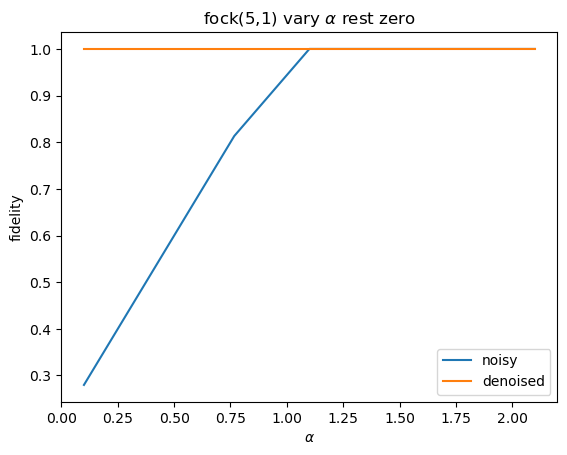

In [5]:
plt.plot(v_alpha, alpha_zero_zero_zero, label=['noisy', 'denoised'])
plt.legend()
plt.title(r'fock(5,1) vary $\alpha$ rest zero')
plt.xlabel(r'$\alpha$')
plt.ylabel('fidelity')

In [6]:
reference = dq.fock(5, 1)
v_b = np.linspace(0.1, 2.1, 7)
one_b_zero_zero = []
for b in v_b:
    temp_fidelity = benchmark_fidelity(reference, 1, b, 0, 0)
    one_b_zero_zero.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 09:50:07 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 09:50:07 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 09:50:07 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 09:50:07 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 09:50:07 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 09:50:07 AM: Compiling problem (target solver=MOSEK).
(C

Text(0, 0.5, 'fidelity')

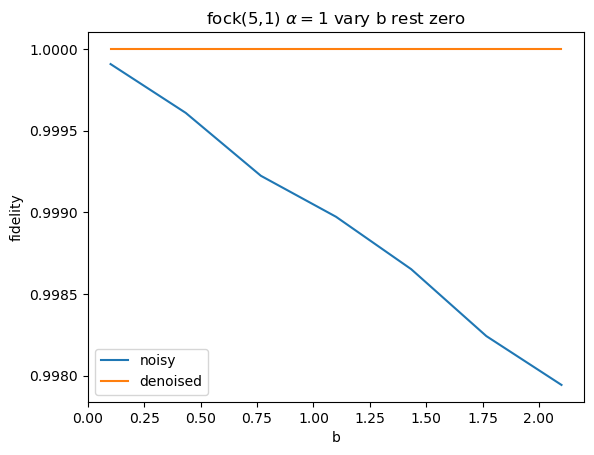

In [7]:
plt.plot(v_b, one_b_zero_zero, label=['noisy', 'denoised'])
plt.legend()
plt.title(r'fock(5,1) $\alpha=1$ vary b rest zero')
plt.xlabel(r'b')
plt.ylabel('fidelity')

In [8]:
reference = dq.fock(5, 1)
v_noise = np.linspace(0, 2, 21)
one_zero_noise_zero = []
for noise in v_noise:
    temp_fidelity = benchmark_fidelity(reference, 1, 0, noise, 0)
    one_zero_noise_zero.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 09:50:18 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 09:50:18 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 09:50:18 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 09:50:18 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 09:50:18 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 09:50:18 AM: Compiling problem (target solver=MOSEK).
(C

Text(0, 0.5, 'fidelity')

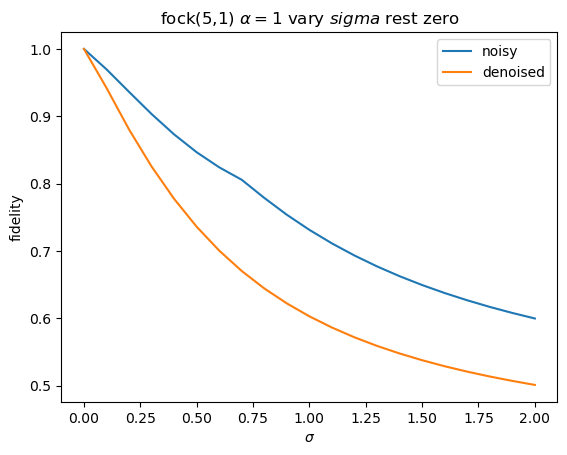

In [9]:
plt.plot(v_noise, one_zero_noise_zero, label=['noisy', 'denoised'])
plt.legend()
plt.title(r'fock(5,1) $\alpha=1$ vary $sigma$ rest zero')
plt.xlabel(r'$\sigma$')
plt.ylabel('fidelity')

In [10]:
reference = dq.fock(5, 1)
v_filter = np.linspace(0, 2, 21)
one_zero_025_filter = []
for filter in v_filter:
    temp_fidelity = benchmark_fidelity(reference, 1, 0, 0.25, filter)
    one_zero_025_filter.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 09:50:53 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 09:50:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 09:50:53 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 09:50:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 09:50:53 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 09:50:53 AM: Compiling problem (target solver=MOSEK).
(C

Text(0, 0.5, 'fidelity')

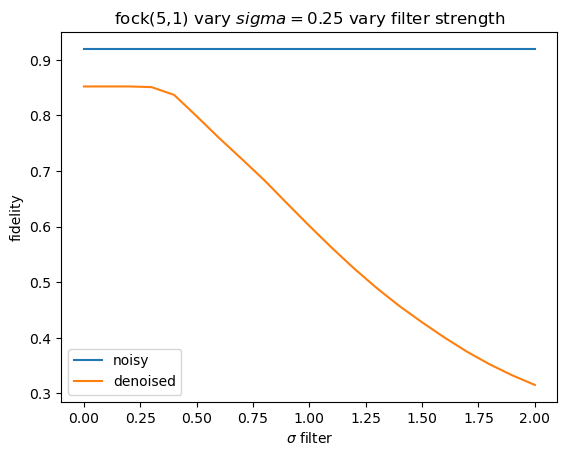

In [11]:
plt.plot(v_filter, one_zero_025_filter, label=['noisy', 'denoised'])
plt.legend()
plt.title(r'fock(5,1) vary $sigma=0.25$ vary filter strength')
plt.xlabel(r'$\sigma$ filter')
plt.ylabel('fidelity')

In [12]:
reference = dq.coherent(5, 3)
#v_filter = np.linspace(0, 2, 21)
coherent_one_zero_025_filter = []
for filter in v_filter:
    temp_fidelity = benchmark_fidelity(reference, 1, 0, 0.25, filter)
    coherent_one_zero_025_filter.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 09:51:29 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 09:51:29 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 09:51:29 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 09:51:29 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 09:51:29 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 09:51:29 AM: Compiling problem (target solver=MOSEK).
(C

Text(0, 0.5, 'fidelity')

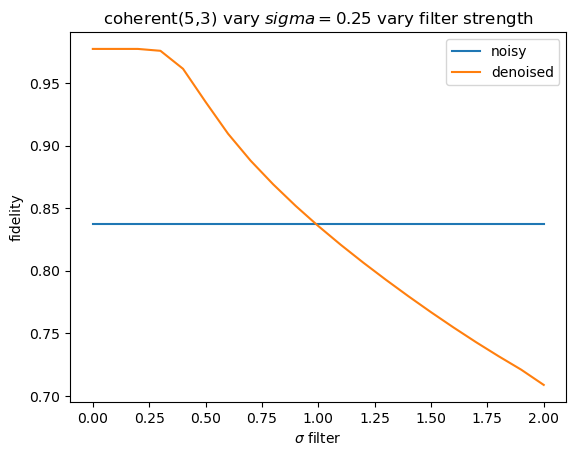

In [13]:
plt.plot(v_filter, coherent_one_zero_025_filter, label=['noisy', 'denoised'])
plt.legend()
plt.title(r'coherent(5,3) vary $sigma=0.25$ vary filter strength')
plt.xlabel(r'$\sigma$ filter')
plt.ylabel('fidelity')

In [18]:
def ncat(n, alpha, dim): # function that returns an n-Cat state with a given phase alpha
    cat = dq.coherent(dim, alpha)
    for k in range(1, n):
        cat += dq.coherent(dim, jnp.exp(2j*jnp.pi*k/n)*alpha)
    return cat/dq.norm(cat)

#test states
fock = dq.fock(5,1)
coherent53 = dq.coherent(5, 3)
cat2 = (dq.coherent(5,3) + dq.coherent(5,-3))
cat2 = cat2/dq.norm(cat2)
cat3 = ncat(3, np.exp(1j *np.pi/2), 5)

v_noise = np.linspace(0, 2, 11)
performance_fock = []
performance_coherent = []
performance_cat2 = []
performance_cat3 = []
for noise in v_noise:
    temp_fock = benchmark_fidelity(fock, 1, 0, noise, 0.25)
    temp_coherent = benchmark_fidelity(coherent53, 1, 0, noise, 0.25)
    temp_cat2 = benchmark_fidelity(cat2, 1, 0, noise, 0.25)
    temp_cat3 = benchmark_fidelity(cat3, 1, 0, noise, 0.25)
    performance_fock.append(temp_fock)
    performance_coherent.append(temp_coherent)
    performance_cat2.append(temp_cat2)
    performance_cat3.append(temp_cat3)
    
performance_fock = np.array(performance_fock)
performance_coherent = np.array(performance_coherent)
performance_cat2 = np.array(performance_cat2)
performance_cat3 = np.array(performance_cat3)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 10:25:15 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 10:25:15 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 10:25:15 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 10:25:15 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 10:25:15 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 10:25:16 AM: Compiling problem (target solver=MOSEK).
(C

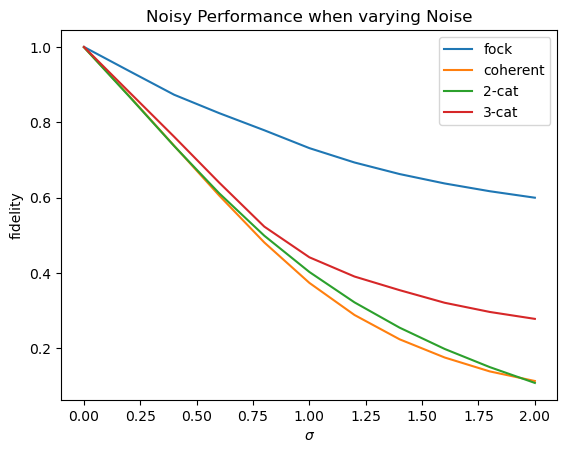

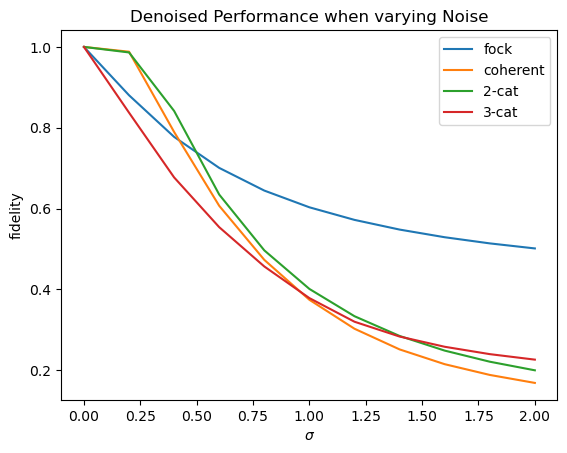

In [20]:
plt.plot(v_noise, performance_fock[:,0], label='fock')
plt.plot(v_noise, performance_coherent[:,0], label='coherent')
plt.plot(v_noise, performance_cat2[:,0], label='2-cat')
plt.plot(v_noise, performance_cat3[:,0], label='3-cat')
plt.legend()
plt.title(r'Noisy Performance when varying Noise')
plt.xlabel(r'$\sigma$')
plt.ylabel('fidelity')
plt.show()

plt.plot(v_noise, performance_fock[:,1], label='fock')
plt.plot(v_noise, performance_coherent[:,1], label='coherent')
plt.plot(v_noise, performance_cat2[:,1], label='2-cat')
plt.plot(v_noise, performance_cat3[:,1], label='3-cat')
plt.legend()
plt.title(r'Denoised Performance when varying Noise')
plt.xlabel(r'$\sigma$')
plt.ylabel('fidelity')
plt.show()

### Reconstruct the experimental Data

In [41]:
def plot_2_wigner(wigner1, wigner2):
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(wigner1.T, interpolation='none')
    #axarr[0].colorbar()
    axarr[1].imshow(wigner2.T, interpolation='none')
    #axarr[1].colorbar()
    axarr[0].title.set_text('Measured')
    axarr[1].title.set_text('Denoised')
    axarr[0].axis('off')
    axarr[1].axis('off')
    plt.show()

0.013367630566243934


<Figure size 640x480 with 0 Axes>

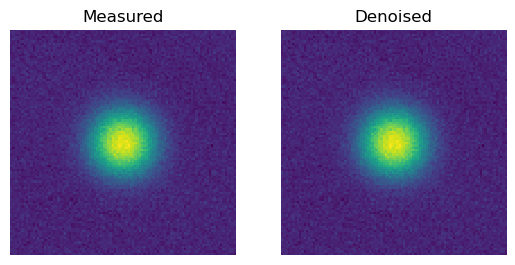

In [42]:
wigner_fock_zero = pd.read_pickle(r'data/experimental/wigner_fock_zero.pickle')
sigma_est_zero = estimate_sigma(wigner_fock_zero[2])
wigner_fock_zero_denoised = remove_affine_gaussian_noise(wigner_fock_zero[2], wigner_fock_zero[0], wigner_fock_zero[1], sigma_est_zero)
print(sigma_est_zero)
plot_2_wigner(wigner_fock_zero[2], wigner_fock_zero_denoised)

0.012127574297922663


<Figure size 640x480 with 0 Axes>

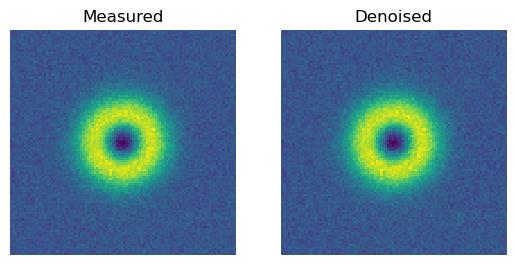

In [43]:
wigner_fock_one = pd.read_pickle(r'data/experimental/wigner_fock_one.pickle')
sigma_est_one = estimate_sigma(wigner_fock_one[2])
wigner_fock_one_denoised = remove_affine_gaussian_noise(wigner_fock_one[2], wigner_fock_one[0], wigner_fock_one[1], sigma_est_one)
print(sigma_est_one)
plot_2_wigner(wigner_fock_one[2], wigner_fock_one_denoised)

0.057060918400340756


<Figure size 640x480 with 0 Axes>

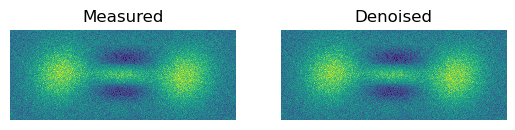

In [44]:
wigner_cat_plus = pd.read_pickle(r'data/experimental/wigner_cat_plus.pickle')
sigma_est_plus = estimate_sigma(wigner_cat_plus[2])
wigner_cat_plus_denoised = remove_affine_gaussian_noise(wigner_cat_plus[2], wigner_cat_plus[0], wigner_cat_plus[1], sigma_est_plus)
print(sigma_est_plus)
plot_2_wigner(wigner_cat_plus[2], wigner_cat_plus_denoised)

0.06286231341564429


<Figure size 640x480 with 0 Axes>

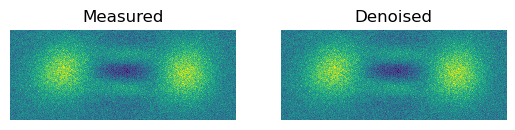

In [45]:
wigner_cat_minus = pd.read_pickle(r'data/experimental/wigner_cat_minus.pickle')
sigma_est_minus = estimate_sigma(wigner_cat_minus[2])
wigner_cat_minus_denoised = remove_affine_gaussian_noise(wigner_cat_minus[2], wigner_cat_minus[0], wigner_cat_minus[1], sigma_est_minus)
print(sigma_est_minus)
plot_2_wigner(wigner_cat_minus[2], wigner_cat_minus_denoised)

0.0794327874811177


<Figure size 640x480 with 0 Axes>

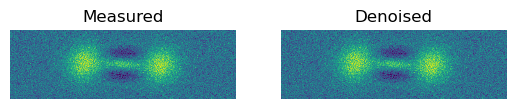

In [46]:
wigner_cat_plus_25 = pd.read_pickle(r'data/experimental/wigner_cat_plus_25.pickle')
sigma_est_plus_25 = estimate_sigma(wigner_cat_plus_25[2])
wigner_cat_plus_25_denoised = remove_affine_gaussian_noise(wigner_cat_plus_25[2], wigner_cat_plus_25[0], wigner_cat_plus_25[1], sigma_est_plus_25)
print(sigma_est_plus_25)
plot_2_wigner(wigner_cat_plus_25[2], wigner_cat_plus_25_denoised)

0.07262522465017969


<Figure size 640x480 with 0 Axes>

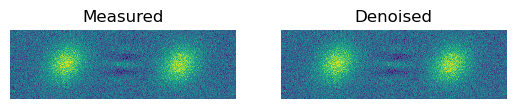

In [47]:
wigner_cat_plus_56 = pd.read_pickle(r'data/experimental/wigner_cat_plus_56.pickle')
sigma_est_plus_56 = estimate_sigma(wigner_cat_plus_56[2])
wigner_cat_plus_56_denoised = remove_affine_gaussian_noise(wigner_cat_plus_56[2], wigner_cat_plus_56[0], wigner_cat_plus_56[1], sigma_est_plus_56)
print(sigma_est_plus_56)
plot_2_wigner(wigner_cat_plus_56[2], wigner_cat_plus_56_denoised)

0.009334923367750375


<Figure size 640x480 with 0 Axes>

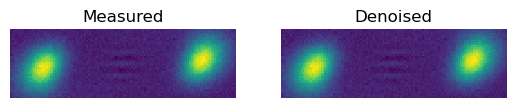

In [48]:
wigner_cat_plus_113 = pd.read_pickle(r'data/experimental/wigner_cat_plus_113.pickle')
sigma_est_plus_113 = estimate_sigma(wigner_cat_plus_113[2])
wigner_cat_plus_113_denoised = remove_affine_gaussian_noise(wigner_cat_plus_113[2], wigner_cat_plus_113[0], wigner_cat_plus_113[1], sigma_est_plus_113)
print(sigma_est_plus_113)
plot_2_wigner(wigner_cat_plus_113[2], wigner_cat_plus_113_denoised)

## Task B

In this subsection, we look at how well common image denoising algorithms perform at denoising our Wigner functions.

In [ ]:
test_noisy_wigner = dq.coherent(5, 3)
reference_wigner = dq.wigner(test_noisy_wigner)
test_noisy_wigner = add_affine_gaussian_noise(reference_wigner[2], 1.5, 1, 0.1)
plt.imshow(test_noisy_wigner.T)
plt.colorbar()

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import (
    calibrate_denoiser,
    denoise_wavelet,
    denoise_tv_chambolle,
    denoise_nl_means,
    estimate_sigma)
from skimage.util import img_as_float, random_noise
from skimage.color import rgb2gray
from functools import partial

In [ ]:
print(np.max(test_noisy_wigner), np.min(test_noisy_wigner))

In [ ]:
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
parameter_ranges = {
    'sigma': np.arange(0.01, 0.3, 0.02),
    'wavelet': ['db1', 'db2'],
    #'convert2ycbcr': [True, False],
    'channel_axis': [-1],
}
# Denoised image using default parameters of `denoise_wavelet`
default_output = denoise_wavelet(test_noisy_wigner, channel_axis=-1, rescale_sigma=True)

# Calibrate denoiser
calibrated_denoiser = calibrate_denoiser(
    test_noisy_wigner, _denoise_wavelet, denoise_parameters=parameter_ranges
)

# Denoised image using calibrated denoiser
calibrated_output = calibrated_denoiser(test_noisy_wigner)

In [ ]:
plt.imshow(calibrated_output.T)
plt.colorbar()

In [ ]:
print(psnr(calibrated_output, reference_wigner[2], data_range=3))

In [ ]:
from skimage.restoration import denoise_invariant

In [ ]:
parameter_ranges_tv = {'weight': np.arange(0.01, 0.3, 0.02)}
_, (parameters_tested_tv, losses_tv) = calibrate_denoiser(
    test_noisy_wigner,
    denoise_tv_chambolle,
    denoise_parameters=parameter_ranges_tv,
    extra_output=True,
)
best_parameters_tv = parameters_tested_tv[np.argmin(losses_tv)]
denoised_calibrated_tv = denoise_invariant(
    test_noisy_wigner, denoise_tv_chambolle, denoiser_kwargs=best_parameters_tv
)
psnr_calibrated_tv = psnr(reference_wigner[2], denoised_calibrated_tv)
print(psnr_calibrated_tv)

In [ ]:
plt.imshow(denoised_calibrated_tv.T)
plt.colorbar()

In [ ]:
sigma_est = estimate_sigma(test_noisy_wigner)

parameter_ranges_nl = {
    'sigma': np.arange(0.6, 1.4, 0.2) * sigma_est,
    'h': np.arange(0.6, 1.2, 0.2) * sigma_est,
}

parameter_ranges_nl = {'sigma': np.arange(0.01, 0.3, 0.03)}
_, (parameters_tested_nl, losses_nl) = calibrate_denoiser(
    test_noisy_wigner, denoise_nl_means, parameter_ranges_nl, extra_output=True
)
best_parameters_nl = parameters_tested_nl[np.argmin(losses_nl)]
denoised_calibrated_nl = denoise_invariant(
    test_noisy_wigner, denoise_nl_means, denoiser_kwargs=best_parameters_nl
)
psnr_calibrated_nl = psnr(reference_wigner[2], denoised_calibrated_nl)
print(psnr_calibrated_nl)

In [ ]:
rescaled_denoised_calibrated_nl = denoised_calibrated_nl#/integrate_wigner(denoised_calibrated_nl, reference_wigner[0], reference_wigner[1])
plt.imshow(rescaled_denoised_calibrated_nl.T)
plt.colorbar()
psnr_calibrated_nl = psnr(reference_wigner[2], rescaled_denoised_calibrated_nl)
print(psnr_calibrated_nl)